# Cross Domain Normalization

In this notebook we test different models with CDN (Cross Domain Nromalization). We'll see that CDN neutralizes the CDS affect and regularizes the model. As a result we outperform state-of-the-art results while significantly speeding up the training time. The models outputs can be found in <font color='red'>./logs/CDN</font> (note that the update rates in the logs are scaled by 100)

In [1]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
import retriever
from tabulate import tabulate
from matplotlib import gridspec
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
trainset_file = '../data/training/w2v_train_data_new.bin'
testset_file = '../data/training/w2v_test_data_new.bin'
vocab_file =  '../data/metadata/vocab.json'
params_dir_tmp = '../data/training/models/CDN/'
embed_path =  '../data/metadata/w2v.bin'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n-1 items where each item is [bounding box vector, bounding box spaital features]. Note that different entries might have different number of possible  bounding boxes (i.e. different n) </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the true bbox </li>
</ul>

In [3]:
trainset = np.load(open(trainset_file, 'rb'))

# delete data points where the query length is zero
trainset = np.array([item for item in trainset if len(item[0])!=0])

testset = np.load(open(testset_file, 'rb'))

# delete data points where the query length is zero
testset = np.array([item for item in testset if len(item[0])!=0])

# loading vocabulary 
with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

print("Number of words:", len(vocab))

Number of words: 8916


In [4]:
# w2c words vectors
embed_vecs = np.load(open(embed_path, 'rb')).astype(np.float32)

In [24]:
def stats(test, train, epochs=100, title=None, params=[50, 100, 150, 200], path=None):
    '''
    Plot metrics graphs and print some stats.
    
    Params:
        test: list. 
              Each item is a tuple, [test accuracy, test IOU, test loss]
        
        train: list. 
               Each item is a tuple, [train accuracy, train IOU, train loss, 0]
               For now we can ignore the last part in the tuple (zero)
               
        params: The hyper-parameters to iterate over, default to number of rnn's hidden units.
        
        path: Where to save the graphs image. If none, do not save. 
        '''
    
    epochs = range(epochs)
    test_res = np.array(test)
    train_res = np.array(train)
    test_Glabels = ['test accuracy', 'test P@1', 'test loss']
    train_Glabels = ['train accuracy', 'train P@1', 'train loss']
    figs = []
    
    
    for j, param in enumerate(params):
        f, P = plt.subplots(1, 3, figsize=(12,4))
       
        for i in range(len(train_Glabels)):
            P[i].plot(epochs, test_res[j][:,i])
            P[i].plot(epochs, train_res[j][:,i])
            P[i].legend([test_Glabels[i], train_Glabels[i]], loc=0)
            if title is not None:
                P[i].set_title('%s'%(title))

            metric = ''.join(train_Glabels[i][len('train')+1:])
            if metric=='loss':
                print('Train loss %s:%.3f'%(metric, min(train_res[j][:,i])))
                print('Test loss %s:%.3f'%(metric, min(test_res[j][:,i])))
            else:
                print('Train %s:%.3f'%(metric, max(train_res[j][:,i])))
                print('Test %s:%.3f'%(metric, max(test_res[j][:,i])))
            P[i].plot()
        plt.show()
        
        if path is not None:
            f.savefig(path+str(params[j])+'_plot.png')
        figs.append(f)
        print('-'*100,'\n')
    return figs

# ALSTM

ALSTM is an LSTM cell to which we feed the phrase's words. However, we've added a new functionality which allows it to attend over the different image's bounding boxes candidates at each timestep.

In [6]:
class ALSTM(tf.nn.rnn_cell.LSTMCell):
    def __init__(self, 
                 batch_size, 
                 num_units, 
                 
                 # Size of attention vector ([image vector, spital features] size) .
                 img_attn_dim, 
                 # Attention vectors
                 img_attn_states, 
                 # img_attn_idx[i,j]=0 if the i-th vector in img_attn_states
                 # is a padding vector
                 img_attn_idx, 
                 # Dropout ratio for rnn's inputs and outpouts
                 dropout_out=1.,
                 dropout_in=1.,
                 use_wordAttn=False,
                 state_is_tuple=True):
        
        super().__init__(num_units, state_is_tuple=state_is_tuple)
    
        self.img_attn_states = img_attn_states
        self.img_attn_idx = img_attn_idx
        self.img_attn_dim = img_attn_dim
        self.use_wordAttn=use_wordAttn
        self.dropout_in = dropout_in
        self.dropout_out = dropout_out
        
        self.num_units = num_units
        self.batch_size = batch_size
        self.cell_tmp = tf.nn.rnn_cell.LSTMCell(self.num_units, state_is_tuple=True)

    def call(self, inputs, state):
        cell = tf.contrib.rnn.DropoutWrapper(
                    self.cell_tmp, output_keep_prob=self.dropout_out, input_keep_prob=self.dropout_in)
        # attention over the BBOXes
        if self.use_wordAttn:
            words_attn = self.attention(state[1], self.img_attn_states, self.img_attn_dim, self.img_attn_idx)
            new_input = tf.concat([inputs, words_attn], -1)
        else:
            new_input=inputs
        outputs, new_state = cell(new_input, state)
        
        return outputs, new_state
    
    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):
        with tf.variable_scope(scope, reuse=False):
            W = tf.get_variable('W', initializer=tf.random_uniform_initializer(maxval=1., minval=-1.),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W) + b

        return tf.matmul(inputs, W)
    
    
    def attention(self, state, attn_states, attn_dim, attn_idx, relu=False):
        '''
        Attention mechanism (see https://arxiv.org/pdf/1409.0473.pdf)
        
        state: State from previous time step.
        attn_states: Attetntion states. 
                     Tensor of shape (batch_size x max([len(attention_vectors[i]) for i in range(batch_size)]) x attn_dim)
        attn_dim: Attention vector size.
        attn_idx,: Tensor used for masking of shape (batch_size x max([len(attention_vectors[i]) for i in range(batch_size)]). 
                   attn_idx[i, j]=1 if the j's attention vcctior of sample i  is not padding, else its equat to 0.
        '''
        with tf.variable_scope('attn'):
            self.attn_length = tf.shape(attn_states)[1]  

            '''
            Computing... hidden_attn = W*v_att (use tf.nn.conv2d for efficiency)
            '''
            # Conv input
            attn_vecs = tf.reshape(
                attn_states, [self.batch_size, self.attn_length, 1, attn_dim]
            )
            # Filter
            W = tf.get_variable("attn_W", [1, 1, attn_dim, self.num_units])
            # hidden_attn shape: (batch_size x attn_length x 1 x num_units)
            hidden_attn = tf.nn.conv2d(attn_vecs, W, [1, 1, 1, 1], "SAME") 

            '''
            Computing... hidden_s = U*v_state
            '''
            # Shape: batch_size x 1 x 1 x num_units
            hidden_s = tf.reshape(
                self.linear(tf.cast(state, tf.float32), output_dim=self.num_units, scope='hidden_s_linear'), 
                [-1, 1, 1,  self.num_units], 
                name='hidden_s'
            )

            '''
            Computing logits...
            '''
            # Shape: batch_size x num_units
            v = tf.get_variable("attn_v", [self.num_units])
            if relu:
                logits = tf.reduce_sum(v * tf.nn.relu(hidden_attn + hidden_s), [2, 3])
            else:
                logits = tf.reduce_sum(v * tf.nn.tanh(hidden_attn + hidden_s), [2, 3])

            # Masked softmax
            max_logits = tf.reduce_max(logits, axis=-1)
            masked_logits = tf.exp(logits-tf.expand_dims(max_logits, axis=1))*attn_idx
            alpha = masked_logits/tf.reduce_sum(masked_logits, axis=-1, keepdims=True)

            # a is the weighted sum of the attention vectors (multiplied by the weights (alpha)) 
            a = tf.reduce_sum(tf.reshape(alpha, [-1, self.attn_length, 1, 1]) * attn_vecs, [1, 2])
            
            # Project a to num_units dimension
            b = tf.contrib.layers.fully_connected(a, num_outputs=self.num_units)


            return b

In [7]:
class Model():
    def __init__(self,
                 batch_size, 
                 num_hidden, 
                 
                 #Image's vector size.
                 img_dims, 
                 
                 #Spaital features length.
                 bbox_dims, 
                 vocab, 
                 lr, # learning rate.
                 decay_steps, 
                 decay_rate, 
                 
                 embed_size=embed_vecs.shape[1],
                 
                 # Whether to uses prefix levlel attention or not.
                 use_wordAttn=False,
                 
                 # Whther to use bidirectional rnn
                 useBidirectionalRnn=False,
                 
                 # We scale the VGG16 LN outputs by IMGscale
                 IMGscale=1,
                 # We scale the language LN outputs by Qscale
                 Qscale=1,
                 ):
        
        self.batch_size = batch_size
        self.img_dims = img_dims
        self.bbox_dims = bbox_dims 
        self.num_hidden = num_hidden
        self.embed_size = embed_size
        self.vocab = vocab
        self.lr = lr
        self.IMGscale=IMGscale
        self.Qscale=Qscale

        self.queries = tf.placeholder(tf.int32, [None, None], name='queries')
        self.img  = tf.placeholder(tf.float32, [None, None, self.img_dims], name='img')# VGG output vectors
        self.bboxes = tf.placeholder(tf.float32, [None, None, self.bbox_dims], name='bboxes')# spatial bbox's features.

        # attn_idx: inicates whether attention box is a pad (0) or not (1).
        self.attn_idx = tf.placeholder(tf.float32, [None, None], name='attn_idx')
        self.labels = tf.placeholder(tf.float32, [None, None], name='labels')
        
        # Dropout ratio for rnn's inputs and outpouts
        self.dropout_in = tf.placeholder(tf.float32, name='dropoutIn_holder')
        self.dropout_out = tf.placeholder(tf.float32, name='dropoutOut_holder')

        # Dropout ratio for attention vector (for the final attention layer before the loss function)
        self.dropout_img = tf.placeholder(tf.float32, name='dropoutImg_holder')
        # Dropout ratio for query vector (for the final attention layer before the loss function)
        self.dropout_q = tf.placeholder(tf.float32, name='dropoutImg_holder')

        self.isTrain = tf.placeholder(tf.bool, name='isTrain_holder') 
        self.queries_lens = self.length(self.queries) # list of all the lengths of the batch's queriey 

        # Concatenate images vectors and their spatial features. 
        # These vectors will be used for attention when
        # we calculate the loss function.
        attn_vecs = tf.concat([self.img, self.bboxes], 2) 
        voc_size = len(self.vocab)

        # Load pre-trained word embeddings.
        # w2v_embed is not trainable.
        with tf.variable_scope('w2v'):
            w2v_embed = tf.get_variable('w2v_embed', initializer=embed_vecs, trainable=False)
            w2v_queries = tf.nn.embedding_lookup(w2v_embed, self.queries, name='w2v_queries')

        with tf.variable_scope('embed'):
            embed = tf.get_variable('embed', shape=[voc_size, self.embed_size], 
                                    initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1))
            embed_queries_tmp = tf.nn.embedding_lookup(embed, self.queries, name='embed_queries')

        embed_queries = embed_queries_tmp+w2v_queries

        with tf.variable_scope('rnn'):
            if use_wordAttn:
                normed_image = self.IMGscale*tf.contrib.layers.layer_norm(self.img, begin_norm_axis=2)
                attn_vecs = tf.concat([normed_image, self.bboxes], 2) 
                
            cell = ALSTM(num_units=self.num_hidden, 
                    img_attn_dim=self.img_dims+self.bbox_dims,
                    img_attn_states=attn_vecs,
                    img_attn_idx=self.attn_idx,
                    batch_size=self.batch_size, 
                    dropout_in=self.dropout_in, dropout_out=self.dropout_out)

            if useBidirectionalRnn:
                self.outputs, self.last_states = tf.nn.bidirectional_dynamic_rnn(
                    cell_fw=cell,
                    cell_bw=cell,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)

                state = tf.concat([self.last_states[0][1], self.last_states[1][1]], -1)
            
            else:
                self.outputs, self.last_states = tf.nn.dynamic_rnn(
                    cell=cell,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)
                state = self.last_states[1]
        
        self.scores = self.CDN_attention(state) 

        self.loss = tf.reduce_mean(-tf.reduce_sum(
                        self.labels*tf.log(self.scores+0.00000001)+
                            (1-self.labels)*tf.log((1-self.scores)+0.00000001), 
                        axis=-1))
            
        
        self.g_rnn =  tf.reduce_mean(tf.norm(tf.gradients(self.loss, self.Urnn)[0], axis=1))
        self.g_img =  tf.reduce_mean(
            tf.reduce_sum(
                tf.norm(
                    tf.gradients(self.loss, self.Uatt)[0]+0.0000000001, axis=2), axis=1)/tf.reduce_sum(self.attn_idx, 1))
        

        ##############
        # Optimizers #
        ##############

        starter_learning_rate = self.lr
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, 
                                                        self.global_step,
                                                        decay_steps=decay_steps, 
                                                        decay_rate=decay_rate, 
                                                        staircase=True)

        self.optimizer =  tf.train.GradientDescentOptimizer(
                    learning_rate=self.learning_rate).minimize(self.loss, global_step=self.global_step)  

        if not os.path.exists(params_dir):
                os.makedirs(params_dir)
        self.saver = tf.train.Saver()

        
    def length(self, seq):
        '''
        Retruns real lengths (before addings) of all queries in seq  .
        '''
        return tf.cast(tf.reduce_sum(tf.sign(tf.abs(seq)), reduction_indices=1), tf.int32)
       

    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):

        with tf.variable_scope(scope, reuse=reuse):
            W1 = tf.get_variable('W1', initializer=tf.contrib.layers.xavier_initializer(),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W1) + b
            
            return tf.matmul(inputs, W1)

    
    def CDN_attention(self, q_embed):
        '''
        Given the queries embeddings, calculate the bboxes scores using CDN.
        That is, calculate:
        
        probs = softmax(relu(<context, Sq+Satt+b>))
        
        Where:
        Sq = <Wq, queries_states>
        Sattn = <Wattn, attention_bboxes_vectors>
        
        The  bounding box with the highest attention score will be chosen as the correct bounding box.
        
        Params:
            q_embed: Tensor of shape (batch size x num_hidden), queries embeddings. 
            
        Returns:
            probs: Tensor of shape (batch_size x max bbox number for query).
                   Attention score for each bbox.
        '''

        self.Urnn = self.Qscale*tf.contrib.layers.layer_norm(q_embed) 
        UattTmp = self.IMGscale*tf.contrib.layers.layer_norm(self.img, begin_norm_axis=2)
        self.Uatt = tf.concat([UattTmp, self.bboxes], 2)
        with tf.variable_scope('CDNAttn') as scope:
            b = tf.get_variable(
                    'b', 
                    initializer=tf.constant_initializer(0.1), 
                    shape=[1, self.num_hidden])

            context = tf.get_variable(
                    'context', 
                    initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), 
                    shape=[self.num_hidden, 1])


            Sq = tf.nn.dropout(
                self.linear(self.Urnn, self.num_hidden, bias=False, scope='Sq'), 
                self.dropout_q)

            Sattn = tf.nn.dropout(
                        tf.reshape(
                            self.linear(
                                tf.reshape(self.Uatt, (-1, self.img_dims+self.bbox_dims)), 
                                self.num_hidden, 
                                bias=False, scope='Sattn'), 
                             [self.batch_size, -1, self.num_hidden]),
                        self.dropout_img)

            out = tf.nn.relu(tf.expand_dims(Sq, 1) + Sattn + b)
            logits = tf.reshape(
                tf.matmul(tf.reshape(out, (-1, tf.shape(out)[-1])),  context), 
                (tf.shape(out)[0], -1)
            )

            # Calculate logits's masked softmax. We use self.attn_idx for 
            # masking the padded BBOXes.
            max_logits = tf.reduce_max(logits*self.attn_idx, axis=-1, keepdims=True)
            masked_logits = tf.exp(logits-max_logits)*self.attn_idx
            probs = masked_logits/tf.reduce_sum(masked_logits, axis=-1, keepdims=True)

            return probs
  
  
        
    def q_padding(self, seq, max_length):
        '''
        Pad  seq with vocab['<pad>'] (0) to max_length length.
        '''                  
        return seq + [self.vocab['<pad>']]*(max_length-len(seq))

    
    def build_data(self, data, start, end):
        '''
        Build batch.
        ------------
        
        Params:
            data: each entry in this list has the following structure:
                  [query indexes, [bounding box vector (VGG), bounding box spaital features], ..., 
                  [bounding box vector (VGG), bounding box spaital features], index of the true label]
                  
            start/end: batch data is built from data[start:end]
            
        Returns:
            attn_idx: attn_idx[i, j]=1 if the j'th bbox in the i'th query is not padding, else equals to 0. 
            
            padded_queries: list of queries, padded to the length of the longest query in the batch.
                            Note: vocab['p<pad>']=0
                            
            padded_im: list of bounding boxes vectors, padded to the maximum number of bbox per query.
                       Note: padded vector is vector of zeros. 
                            
            padded_bbox: list of bounding boxes spatial features, padded to the maximum number of bbox per query.
                         Note: padded vector is vector of zeros.  
        
            dist_labels: dist_labels[i][j]=1 if j is the true bbox for query i, else dist_labels[i][j]=0
                        
        '''
                      
        qlen = max([len(data[i][0]) for i in range(start, end)]) # Length fo the longest query
        imlen = max([len(data[i]) for i in range(start, end)])-2 # Maximum number of bbox per query.
        padded_queries, padded_im, padded_bbox, attn_idx = [], [], [], []
        
        # Build one hot labels from the labels index, given in the data.                  
        labels = [item[-1] for item in data[start:end]] # data[i][-1]=index of the true bbox of query i
        dist_labels = np.zeros((end-start, imlen)) #label distribution
        dist_labels[[i for i in np.arange(end-start)], [l for l in labels]]=1
        
        im_dim, bbox_dim = data[0][1][0].shape[1], data[0][1][1].shape[1]
        for i in range(start, end):
            padded_queries.append(self.q_padding(data[i][0], qlen))
            
            attn_idx.append(
                [1 for _ in range(len(data[i])-2)]+[0 for _ in range(imlen-(len(data[i])-2))])
            
            padded_im.append(
                np.concatenate(
                    [data[i][j][0] for j in range(1, len(data[i])-1)] + 
                        [np.full((imlen-(len(data[i])-2), im_dim), vocab['<pad>'], dtype=np.float32)], 
                    axis=0)
            )
            
            padded_bbox.append(
                np.concatenate(
                    [data[i][j][1] for j in range(1, len(data[i])-1)] + 
                        [np.full((imlen-(len(data[i])-2),bbox_dim), vocab['<pad>'], dtype=np.float32)], 
                    axis=0)
            )
           
        return np.array(attn_idx), np.array(padded_queries, dtype=np.int32), np.array(padded_im), np.array(padded_bbox), np.array(dist_labels)
            
   
    def ground(self, data=None, start=None, end=None, 
               sess=None, feed_dict = None, scores=[]):
        '''
        Given a query and a list of bboxes, the function returns the index of the chosen bbox and the ground truth bbox.
        
        Params:
            data: A numpy array with datasat's data points
            start/end: The function only take data points from data[start:end]
            imScale: whether to scale the images vectors
        '''
        isSess = (sess==None)
        if isSess:
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(
                    data, start, end)
                    
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.labels:labels,
                        self.attn_idx:attn_idx}
                    
            if len(scores)==0:
                feed_dict[self.isTrain]=False
                feed_dict[self.dropout_in]=1.
                feed_dict[self.dropout_out]=1.
                feed_dict[self.dropout_img]=1.
                feed_dict[self.dropout_q]=1.
                scores = sess.run(self.scores, feed_dict=feed_dict) # get score for each bbox

        return np.argmax(scores, axis=1), np.argmax(feed_dict[self.labels], axis=1)
        
        
    def iou_accuracy(self, data=None, start=None, end=None, sess=None, 
                     feed_dict=None, threshold=0.5, test=False, scores=[]):
        '''
        Calculate the IOU score between the Model bbox and the true bbox.
        
         Params:
            data: A numpy array with datasat's data points
            start/end: The function only take data points from data[start:end]
            imScale: whether to scale the images vectors
            threshold: If IOU>0.5 this is a true positive
        ''' 
                          
        # Get score for each bbox (labels) and th true bbox index (gt_idx)                  
        labels, gt_idx = self.ground(data, start, end, sess=sess, feed_dict=feed_dict, scores=scores)
        acc = 0
        
        for i in range(start, end):
            gt = data[i][gt_idx[i-start]+1][1][0] # ground truth bbox. Note that len(data)!=len(gt_idx)=batch_size
            crops = np.expand_dims(data[i][labels[i-start]+1][1][0], axis=0) # predicted bbox.. Note that len(data)!=len(labels)=batch_size
            acc += (retriever.compute_iou(crops, gt)[0]>threshold) #IOU for the i-th sample.
            
        return acc/(end-start)
        
    def accuracy(self, data=None, start=None, end=None, sess=None, 
                 feed_dict=None, scores=[]):
        isSess = (sess==None)
        if isSess:
            print('Building sess')
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                print('Building sess used')
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    print('3')
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                print('Building feed_dict')
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(data, start, end)
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels:labels,
                    }
                
            loss = 0
            if len(scores)==0:
                feed_dict[self.isTrain]=False
                feed_dict[self.dropout_in]=1.
                feed_dict[self.dropout_out]=1.
                feed_dict[self.dropout_img]=1.
                feed_dict[self.dropout_q]=1.
                loss, scores = sess.run([self.loss, self.scores], feed_dict=feed_dict)
                    
            acc = sum(
                np.equal(
                    np.argmax(scores, axis=1), 
                    np.argmax(feed_dict[self.labels], axis=1))/len(feed_dict[self.labels])
            )
          
        return loss, scores, acc

    def train(self, trn_data, tst_data, epochs_num,  start_epoch=0, dropout_in=1.,
              dropout_out=1., dropout_img=1., dropout_q=1.):
                          
        '''
        Params:
            trn_data: list, train set. 
             
            tst_data: list, test set. 
             
            epochs_num: number of epochs
             
            start_epoch: number of first epoch. 
            
            dropout_in: dropout ratio of rnn inputs.
            
            dropout_output: dropout ratio of rnn output.
            
            dropout_img: dropout ratio of images vectors before the last attention layer .
        '''                  
        
        trn_nbatch = len(trn_data)//self.batch_size
        tst_nbatch = len(tst_data)//self.batch_size

        
        # list to hold accuracy and loss of test and train sets
        self.test_res, self.train_res = [], [] 
        
        sess = tf.Session()
        with sess.as_default():
            tf.global_variables_initializer().run()
            ckpt = tf.train.get_checkpoint_state(params_dir)
            if ckpt and ckpt.model_checkpoint_path:
                print('Loading parameters from', ckpt.model_checkpoint_path)
                self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
            else:
                print('Initializing variables')
                
            qMean_list, qSTD_list, qRange_list, imgMean_list, imgSTD_list, imgRange_list = [], [], [], [], [], []
            Gq, Gimg = [], []
            for epoch in range(start_epoch, epochs_num):
                    
                ############
                # Training #
                ############
                    
                startTime = datetime.now().replace(microsecond=0)   
                print('='*50,'\nTrain, epoch:',epoch)
                np.random.shuffle(trn_data)
                trn_loss, trn_acc, trn_iou = 0, 0, 0
                qMean, qSTD, qRange, imgMean, imgSTD, imgRange = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
                g_img, g_rnn = 0.0, 0.0
                
                for b in range(trn_nbatch):
                    attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(trn_data, 
                                                                                        b*self.batch_size, 
                                                                                        (b+1)*self.batch_size)

                    feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels: labels,
                        self.dropout_in:dropout_in,
                        self.dropout_out:dropout_out,
                        self.dropout_img:dropout_img,
                        self.dropout_q:dropout_q,
                        self.isTrain:True
                    }
                    
                    g_rnn_tmp, g_img_tmp, scores, Urnn, Uatt, loss, lr, gs,  _ = sess.run([self.g_rnn, 
                                                      self.g_img, self.scores, self.Urnn, self.Uatt, 
                                                        self.loss, self.learning_rate, 
                                                        self.global_step, self.optimizer], feed_dict=feed_dict)
                    
                    Urnn_tmp = np.reshape(Urnn, (-1, 200))
                    qMean_tmp = np.mean(np.mean(Urnn_tmp, axis=0))
                    qSTD_tmp = np.mean(np.std(Urnn_tmp, axis=0))
                    qRange_tmp = np.mean(np.max(Urnn_tmp, axis=0) - np.min(Urnn_tmp, axis=0))
                    
                    Uatt_tmp = np.reshape(Uatt[:,:,:4096], (-1, 4096)) 
                    imgSTD_tmp = np.mean(np.std(Uatt_tmp, 0))
                    imgMean_tmp = np.mean(Uatt_tmp)
                    
                    # making sure the padds wont be taken into considiration
                    # idx = the raws number that are not paddings in  Uattn
                    attn_idx_tmp = np.reshape(attn_idx, (-1,))
                    idx = [i for j, i in  enumerate(range(len(attn_idx_tmp))) if attn_idx_tmp[j]!=0]
                    #print(sum(attn_idx_tmp), sum(np.sign(idx)))
                    #idx =  np.arange(len(attn_idx_tmp))*attn_idx_tmp
                    Uatt_tmp = np.reshape(Uatt[:,:,:4096], (-1, 4096))[idx,:]
                    imgSTD_tmp = np.mean(np.std(Uatt_tmp, 0))
                    imgMean_tmp = np.mean(np.mean(Uatt_tmp,0))
                    imgRange_tmp= np.mean(np.max(Uatt_tmp, axis=0) - np.min(imgMean_tmp, axis=0))
                    
                    qMean += qMean_tmp
                    qSTD +=qSTD_tmp
                    qRange += qRange_tmp

                    imgMean += imgMean_tmp
                    imgSTD +=imgSTD_tmp
                    imgRange += imgRange_tmp
                       
                    g_img += g_img_tmp
                    g_rnn += g_rnn_tmp
                    

                    loss, scores, acc = self.accuracy(sess=sess, feed_dict=feed_dict)  
                    iou_acc = self.iou_accuracy(trn_data, b*self.batch_size, (b+1)*self.batch_size,
                                                sess=sess, feed_dict=feed_dict, scores=scores)

                    trn_acc += acc/trn_nbatch
                    trn_loss += loss/trn_nbatch
                    trn_iou += iou_acc/trn_nbatch

                    if b%50==0:
                        print('b:%d'%(b),  
                                ';lr:%.3f'%(lr),
                                ';loss:%.2f'%(loss), ';acc:%.2f'%(acc), 
                                ';iou:%.2f'%(iou_acc),
                                ';qMean:%.2f'%(qMean_tmp),
                                ';qSTD:%.2f'%(qSTD_tmp),
                                ';iMean:%.2f'%(imgMean_tmp),
                                ';iSTD:%.2f'%(imgSTD_tmp),
                                ';qRange:%.2f'%(qRange_tmp),
                                ';iRange:%.2f'%(imgRange_tmp),
                                ';Gq:%.5f'%(g_rnn_tmp*100),
                                ';Gi:%.5f'%(g_img_tmp*100),
                                ';time:', datetime.now().replace(microsecond=0)-startTime)

                print('\n*Tr loss: %.3f'%(trn_loss),';Tr acc: %.3f'%(trn_acc), 
                        ';IOU acc: %.3f'%(trn_iou),  
                        ';qMean:%.3f'%(qMean/trn_nbatch),
                        ';qSTD:%.3f'%(qSTD/trn_nbatch),
                        ';iMean:%.3f'%(imgMean/trn_nbatch),
                        ';iSTD:%.3f'%(imgSTD/trn_nbatch),
                        ';qRange:%.3f'%(qRange/trn_nbatch),
                        ';imgRange:%.3f'%(imgRange/trn_nbatch),
                        ';Gq:%.5f'%(g_rnn*100/trn_nbatch),
                        ';Gi:%.5f'%(g_img*100/trn_nbatch),

                      ';Time:', datetime.now().replace(microsecond=0)-startTime, '\n')

                imgMean_list.append(imgMean/trn_nbatch)
                imgSTD_list.append(imgSTD/trn_nbatch)
                qMean_list.append(qMean/trn_nbatch)
                qSTD_list.append(qSTD/trn_nbatch)
                qRange_list.append(qRange/trn_nbatch)
                imgRange_list.append(imgRange/trn_nbatch)
                Gq.append(g_rnn/trn_nbatch)
                Gimg.append(g_img/trn_nbatch)
               
                self.train_res.append([trn_acc, trn_iou, trn_loss])    
                
                self.saver.save(sess, params_dir + "/model.ckpt", global_step=epoch)
                
                ###########
                # Testing #
                ###########
                    
                print('Testing, epoch:',epoch)
                tstTime = datetime.now().replace(microsecond=0)
                tst_loss, tst_acc, tst_iou = 0, 0, 0
                for b in range(tst_nbatch):
                    attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(tst_data,
                                                                                        b*self.batch_size, 
                                                                                        (b+1)*self.batch_size)
                    feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels: labels,
                        self.dropout_in:1.,
                        self.dropout_out:1.,
                        self.dropout_img:1.,
                        self.dropout_q:1.,
                        self.isTrain:False
                    }
                    scores, loss = sess.run([self.scores, self.loss], feed_dict=feed_dict)
                    _,_, acc = self.accuracy(sess=sess, feed_dict=feed_dict, scores=scores)
                    iou_acc = self.iou_accuracy(
                        tst_data, b*self.batch_size, int(b+1)*self.batch_size, sess=sess, 
                        feed_dict=feed_dict, scores=scores)

                    tst_acc += acc/tst_nbatch
                    tst_loss += loss/tst_nbatch
                    tst_iou += iou_acc/tst_nbatch
                    if b%50==0:
                        print('batch:', b, ';loss: %.3f'%(loss), ';acc: %.3f'%(acc), 
                               ';iou_acc: %.3f'%(iou_acc), ';time:', 
                              datetime.now().replace(microsecond=0)-startTime)
                    
                print('\n*Test loss: %.3f'%(tst_loss), ';Test accuracy %.3f'%(tst_acc), 
                      ';Test IOU: %.3f'%(tst_iou), ';Time:', datetime.now().replace(microsecond=0)-startTime)
                self.test_res.append([tst_acc, tst_iou, tst_loss])
            print('='*50,'\n')
        return self.test_res, self.train_res, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg


## Random Search

We start by searching for the best STD for both the image and the language models. We show here just a few of the values we've tested. The best results were achieved by setting the image STD to 0.023 and the language STD to 0.16. Note that while these values gave the best results, by lowering the image STD we can improve the model regularization with only a small cost in terms of P@1 (IOU). 

In [2]:
CDN_tst, CDN_trn, CDN_params = [], [], []
scales = np.random.random_sample((5, 2))*(1/40, 0.5)
print('scales:\n',scales, '\n')
for i, scale in enumerate(scales):
    tf.reset_default_graph()
    params_dir = params_dir_tmp+'CDNsearch_'+str(i)
    m = Model(
        batch_size=200, 
        num_hidden=200,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=testset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        Qscale=scale[1],
        IMGscale= scale[0])


    print('params_dir:', params_dir)
    print('Img scale:', scale[0])
    print('Txt scale:', scale[1])
    print('learning rate:', m.lr)

    tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
        trainset, testset, epochs_num=40)

    CDN_tst.append(tst)
    CDN_trn.append(trn)
    CDN_params.append([scale, imgMean_list, imgSTD_list, imgRange_list, 
                       qMean_list, qSTD_list, qRange_list, Gq, Gimg])
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

Train accuracy:0.812
Test accuracy:0.732
Train IOU:0.880
Test IOU:0.818
Train loss loss:0.912
Test loss loss:1.225


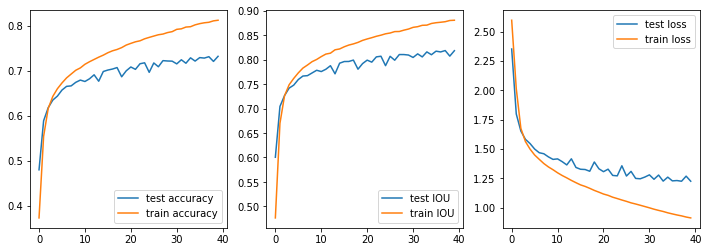

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.807
Test accuracy:0.712
Train IOU:0.877
Test IOU:0.801
Train loss loss:0.937
Test loss loss:1.308


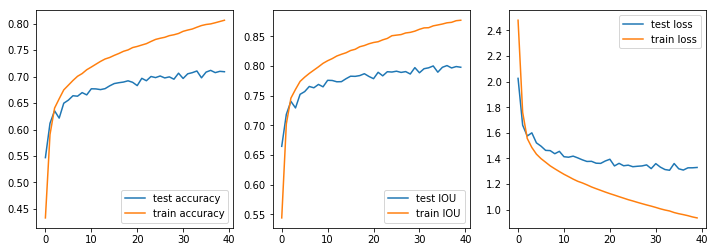

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.838
Test accuracy:0.730
Train IOU:0.901
Test IOU:0.816
Train loss loss:0.813
Test loss loss:1.236


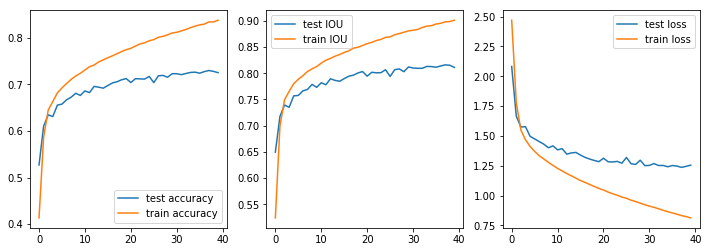

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.860
Test accuracy:0.743
Train IOU:0.915
Test IOU:0.825
Train loss loss:0.729
Test loss loss:1.189


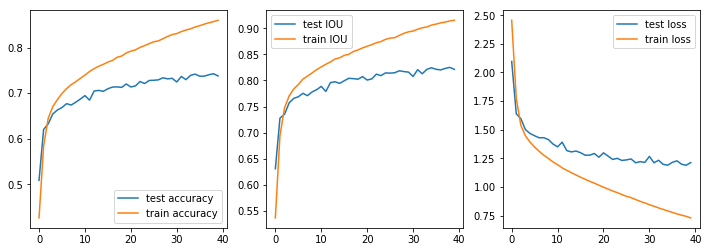

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.823
Test accuracy:0.730
Train IOU:0.889
Test IOU:0.816
Train loss loss:0.866
Test loss loss:1.227


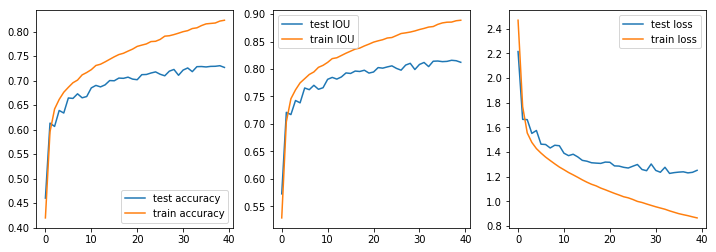

---------------------------------------------------------------------------------------------------- 



In [47]:
f = stats(CDN_tst, CDN_trn, epochs=40, params=[1,2,3,4,5])

## CDN

<p>Here we can see the results while using SG with CDN. The graphs show a much more stable behavior and a significant reduction in overfit which leads to a better P@1 and a lower loss.</p>

<p> Furthermore, CDN accelerates the training process. Without CDN we've got P@1 of 0.66 after 98 epochs, this result was outperform at the first epoch by only adding CDN, which achieved 0.846 P@1. In addition, with CDN the model trains about 4.4 times faster than GroundeR and 3.7 times faster than SG+SBN. While it took 96 epochs to get to 0.819 P@1 with GroundeR (SG + BN layers over the image and language models), with CDN we got to 0.822 P@1 after only 22 epochs. For SG+SBN (Scaled Batch Normalization) we also got the best P@1 (0.831) after 96 ephochs, while SG+CDN got to the same P@1 after only 26 epochs.</p>

In [3]:
params_dir = params_dir_tmp+'CDN'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    Qscale=0.16,
    IMGscale=0.023)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=60)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')



Train accuracy:0.920
Test accuracy:0.770
Train P@1:0.954
Test P@1:0.846
Train loss loss:0.475
Test loss loss:1.113


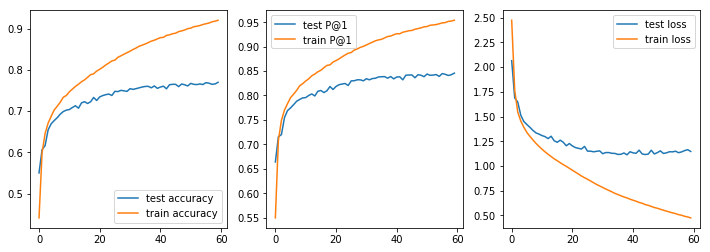

---------------------------------------------------------------------------------------------------- 



In [33]:
f = stats([tst], [trn], epochs=60, params=[200])

The source of the improvement can be seen by examining the update rates of the image and language models, CDN keeps the ratio between the update rates more stable. Note that unlike other experiments, where the loss increased once the ratio between update rates became too small, with CDN the loss decreases even when the ratio is one. 

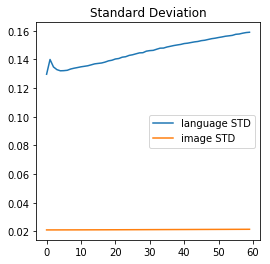

In [15]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=60

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

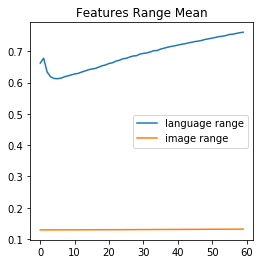

In [18]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=60

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:60])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

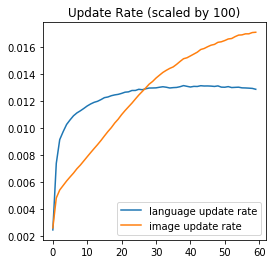

In [17]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
epochs=60

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()

## CDND 

Next we add dropout before and after the LSTM cell. CDN has the same effect as we saw in the previous experiment, however with dropout we get a better P@1. 

In [19]:
params_dir = params_dir_tmp+'CDNdrop'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    Qscale=0.16,
    IMGscale=0.023)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=100, dropout_in=0.5, dropout_out=0.5)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:0.905
Test accuracy:0.779
Train IOU:0.942
Test IOU:0.853
Train loss loss:0.524
Test loss loss:1.038


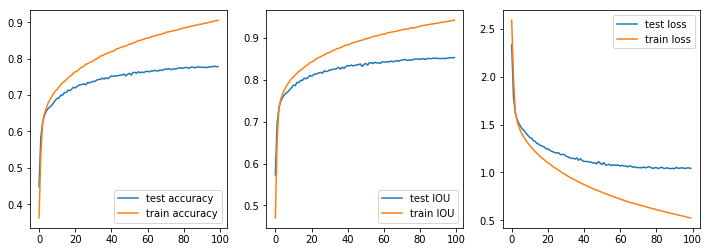

---------------------------------------------------------------------------------------------------- 



In [21]:
f = stats([tst], [trn], epochs=100, params=[200])

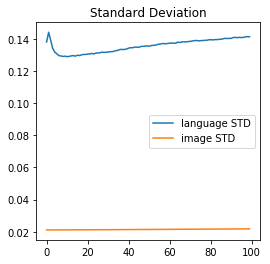

In [22]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

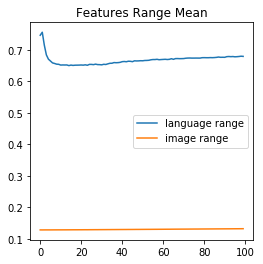

In [24]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

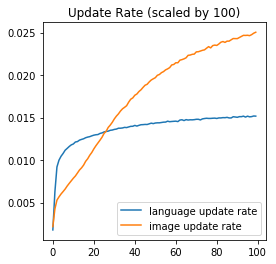

In [25]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()

<b>The following experiments test SG+CDN with bidirectional RNN, attention and both, in all experiments we used dropout only before the LSTM cell.</b>

<p>We see that adding bidirectional RNN and/or attention has only little effect on the models statistics. We get the best results with bidirectional RNN and with bidirectional RNN + attention, which yield similar results. Note that without CDN we saw that the attention mechanism was mainly used for overfitting, however, with CDN, attention improves the results in terms of both P@1 and regularization. </p>

## BiCDND

Bidirectional RNN + CDN + Dropout

In [4]:
params_dir = params_dir_tmp+'BiCDNdrop'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    useBidirectionalRnn=True,
    Qscale=0.16,
    IMGscale=0.023)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=100, dropout_in=0.5, dropout_out=1.)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:0.929
Test accuracy:0.786
Train P@1:0.959
Test P@1:0.858
Train loss loss:0.416
Test loss loss:1.028


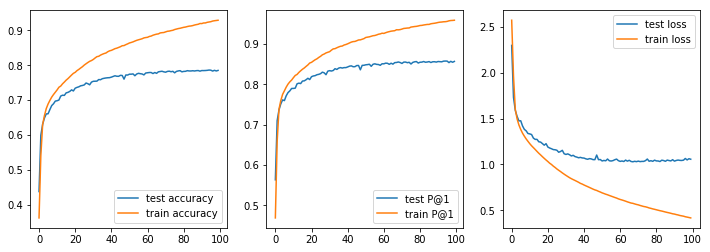

---------------------------------------------------------------------------------------------------- 



In [15]:
f = stats([tst], [trn], epochs=100, params=[200])

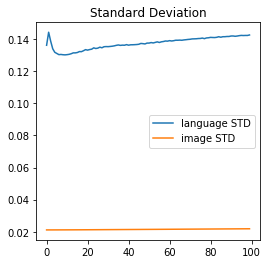

In [13]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

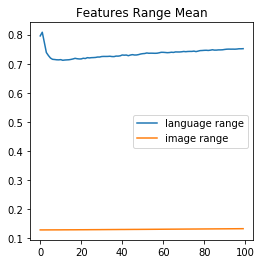

In [15]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

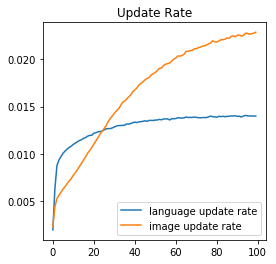

In [12]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()

## Attention CDND

prefix attention + CDN + Dropout

In [20]:
params_dir = params_dir_tmp+'attnCDN'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    Qscale=0.16,
    use_wordAttn=True,
    IMGscale=0.023)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=100, dropout_in=0.5, dropout_out=1)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:0.902
Test accuracy:0.777
Train P@1:0.940
Test P@1:0.853
Train loss loss:0.535
Test loss loss:1.046


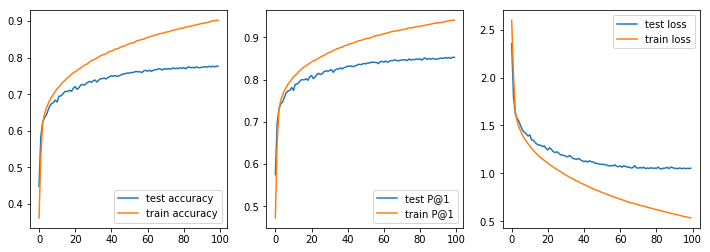

---------------------------------------------------------------------------------------------------- 



In [10]:
f = stats([tst], [trn], epochs=100, params=[200])

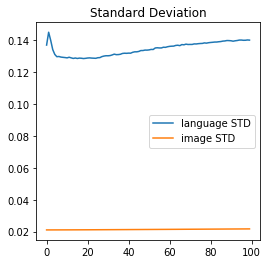

In [11]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

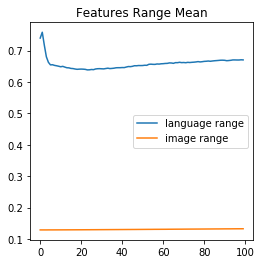

In [13]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

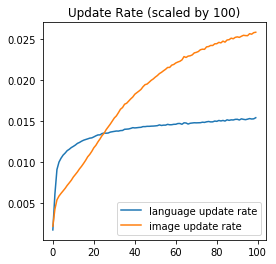

In [11]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()

## Attention and Bi CDND

Bidirectional RNN + prefix attention + CDN + Dropout

In [21]:
params_dir = params_dir_tmp+'attnBiCDN'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    Qscale=0.16,
    use_wordAttn=True,
    useBidirectionalRnn=True,
    IMGscale=0.023)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=100, dropout_in=0.5, dropout_out=1)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:0.927
Test accuracy:0.783
Train P@1:0.958
Test P@1:0.857
Train loss loss:0.426
Test loss loss:1.035


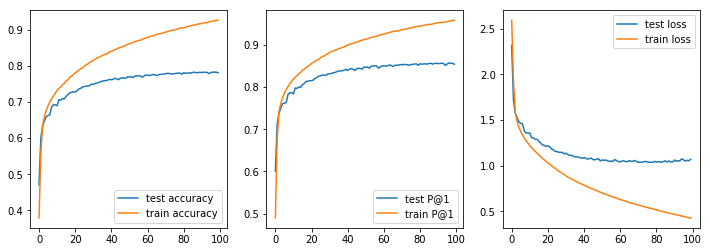

---------------------------------------------------------------------------------------------------- 



In [25]:
f = stats([tst], [trn], epochs=100, params=[1])

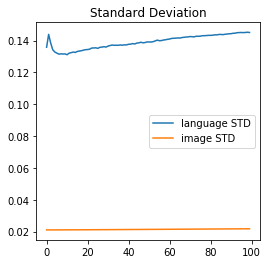

In [17]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

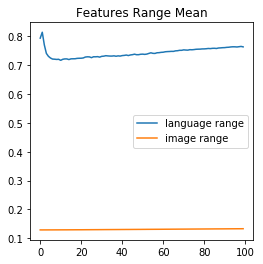

In [18]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

Train accuracy:0.927
Test accuracy:0.783
Train P@1:0.958
Test P@1:0.857
Train loss loss:0.426
Test loss loss:1.035


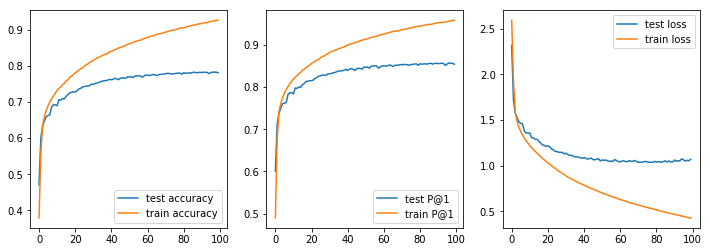

---------------------------------------------------------------------------------------------------- 



In [14]:
f = stats([tst], [trn], epochs=100, params=[1])

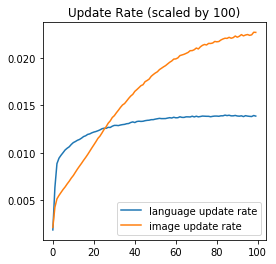

In [16]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()